#### Import all helper libraries

In [1]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
from torchvision import models
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.ion()

### List all the files in input directory

In [2]:
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input\X.npy
../input\Y.npy


### Read the data from input directory
About the data: Sign languages (also known as signed languages) are languages that use manual communication to convey meaning. This can include simultaneously employing hand gestures, movement, orientation of the fingers, arms or body, and facial expressions to convey a speaker's ideas. <br/>
- Image size: 64x64
- Color space: Grayscale
- File format: npy
- Number of classes: 10 (Digits: 0-9)

In [3]:
X = np.load('../input\X.npy')
y = np.load('../input\Y.npy')

In [4]:
print(X.shape[0], X.shape[1])
print(y.shape[0], y.shape[1])
print(X[0].shape)

2062 64
2062 10
(64, 64)


The dataset has wrong mapping between features and targets. 

In [5]:
Y = np.zeros(X.shape[0])

Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
x_train, x_test, y_train, y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = .02, 
                                                    random_state = 2
                                                   )

In [6]:
print(x_train.shape, y_train.shape)

(2020, 64, 64) (2020,)


### Data preprocessing

In [7]:
class DatasetProcessing(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.float32)[:,:,:,None]
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.transform(self.data[index]), self.target[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))
    

In [8]:
transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])


dset_train = DatasetProcessing(x_train, y_train, transform)


train_loader = torch.utils.data.DataLoader(dset_train, batch_size=4,
                                          shuffle=True, num_workers=4)

In [9]:
transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])


dset_train = DatasetProcessing(x_train, y_train, transform)


train_loader = torch.utils.data.DataLoader(dset_train, batch_size=4,
                                          shuffle=True, num_workers=4)
dset_test = DatasetProcessing(x_test, y_test, transform)
test_loader = torch.utils.data.DataLoader(dset_test, batch_size=4,
                                          shuffle=True, num_workers=4)

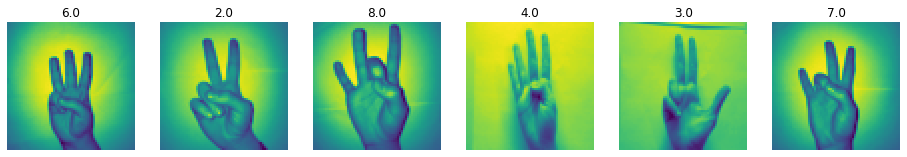

In [10]:
plt.figure(figsize = (16, 4))
for num, x in enumerate(x_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

### Model Architecture 

In [11]:
class Net(nn.Module):    
    
    # This constructor will initialize the model architecture
    def __init__(self):
        super(Net, self).__init__()
          
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # Putting a 2D Batchnorm after CNN layer
            nn.BatchNorm2d(32),
            # Adding Relu Activation
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
          
        self.linear_layers = nn.Sequential(
            # Adding Dropout
            nn.Dropout(p = 0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        
    # Defining the forward pass    
    def forward(self, x):
        
        # Forward Pass through the CNN Layers 
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # Forwrd pass through Fully Connected Layers
        x = self.linear_layers(x)
        return F.log_softmax(x) 

In [12]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [13]:
def train(epoch):
    model.train()
    exp_lr_scheduler.step()
    tr_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        # Clearing the Gradients of the model parameters
        optimizer.zero_grad()
        output = model(data)
        pred = torch.max(output.data, 1)[1]
        correct += (pred == target).sum()
        total += len(data)
        
        # Computing the loss
        loss = criterion(output, target)
        
        # Computing the updated weights of all the model parameters
        loss.backward()
        optimizer.step()
        tr_loss = loss.item()
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} \t Accuracy: {} %'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(),100 * correct / total))
            torch.save(model.state_dict(), './model.pth')
            torch.save(model.state_dict(), './optimizer.pth')
    train_loss.append(tr_loss / len(train_loader))
    train_accuracy.append(100 * correct / total)

In [14]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    for data, target in data_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        loss += F.cross_entropy(output, target, size_average=False).item()
        pred = torch.max(output.data, 1)[1]
        total += len(data)
        correct += (pred == target).sum()
    loss /= len(data_loader.dataset)
    valid_loss.append(loss)    
    valid_accuracy.append(100 * correct / total)
    print('\nAverage Validation loss: {:.5f}\tAccuracy: {} %'.format(loss, 100 * correct / total))

In [16]:
n_epochs = 50
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
for epoch in range(n_epochs):
    train(epoch)
    evaluate(test_loader)

BrokenPipeError: [Errno 32] Broken pipe